<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SHAP-Decision-Plots" data-toc-modified-id="SHAP-Decision-Plots-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SHAP Decision Plots</a></span><ul class="toc-item"><li><span><a href="#Load-the-dataset-and-train-the-model" data-toc-modified-id="Load-the-dataset-and-train-the-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the dataset and train the model</a></span></li><li><span><a href="#Calculate-SHAP-values" data-toc-modified-id="Calculate-SHAP-values-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Calculate SHAP values</a></span></li></ul></li><li><span><a href="#Basic-decision-plot-features" data-toc-modified-id="Basic-decision-plot-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic decision plot features</a></span></li><li><span><a href="#When-is-a-decision-plot-helpful?" data-toc-modified-id="When-is-a-decision-plot-helpful?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>When is a decision plot helpful?</a></span><ul class="toc-item"><li><span><a href="#Show-a-large-number-of-feature-effects-clearly" data-toc-modified-id="Show-a-large-number-of-feature-effects-clearly-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Show a large number of feature effects clearly</a></span></li><li><span><a href="#Visualize-multioutput-predictions" data-toc-modified-id="Visualize-multioutput-predictions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualize multioutput predictions</a></span></li><li><span><a href="#Display-the-cumulative-effect-of-interactions" data-toc-modified-id="Display-the-cumulative-effect-of-interactions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Display the cumulative effect of interactions</a></span></li><li><span><a href="#Explore-feature-effects-for-a-range-of-feature-values" data-toc-modified-id="Explore-feature-effects-for-a-range-of-feature-values-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Explore feature effects for a range of feature values</a></span></li><li><span><a href="#Identify-outliers" data-toc-modified-id="Identify-outliers-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Identify outliers</a></span></li><li><span><a href="#Identify-typical-prediction-paths" data-toc-modified-id="Identify-typical-prediction-paths-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Identify typical prediction paths</a></span></li><li><span><a href="#Compare-and-contrast-predictions-for-several-models" data-toc-modified-id="Compare-and-contrast-predictions-for-several-models-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Compare and contrast predictions for several models</a></span></li></ul></li><li><span><a href="#SHAP-interaction-values" data-toc-modified-id="SHAP-interaction-values-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SHAP interaction values</a></span></li><li><span><a href="#Preserving-order-and-scale-between-plots" data-toc-modified-id="Preserving-order-and-scale-between-plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Preserving order and scale between plots</a></span></li><li><span><a href="#Selecting-features-for-display" data-toc-modified-id="Selecting-features-for-display-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Selecting features for display</a></span></li><li><span><a href="#Changing-the-SHAP-base-value" data-toc-modified-id="Changing-the-SHAP-base-value-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Changing the SHAP base value</a></span></li></ul></div>

# SHAP Decision Plots
SHAP decision plots show how complex models arrive at their predictions (i.e., how models make decisions). This notebook illustrates decision plot features and use cases with simple examples. For a more descriptive narrative, [click here](https://medium.com/@floidgilbert/introducing-shap-decision-plots-52ed3b4a1cba).

## Load the dataset and train the model
For most of the examples, we empoy a [LightGBM](https://github.com/microsoft/LightGBM) model trained on the [UCI Adult Income](https://archive.ics.uci.edu/ml/datasets/adult) data set. The objective: predict whether an individual makes over $50K per year.

In [1]:
from pprint import pprint
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.277144


## Calculate SHAP values
Compute SHAP values and SHAP interaction values for the first 20 test observations.

In [2]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: -2.4296968952292404


# Basic decision plot features
Refer to the decision plot of the 20 test observations below. *Note: This plot isn't informative by itself; we use it only to illustrate the primary concepts.*
* The x-axis represents the model's output. In this case, the units are log odds.
* The plot is centered on the x-axis at `explainer.expected_value`. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.
* The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. *This is usually different than the importance ordering for the entire dataset.* In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
* Each observation's prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
* Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model's base value. This shows how each feature contributes to the overall prediction.
* At the bottom of the plot, the observations converge at `explainer.expected_value`.

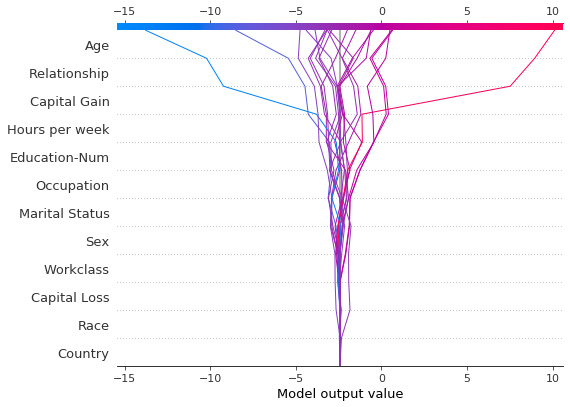

In [3]:
shap.decision_plot(expected_value, shap_values, features_display)

Like the force plot, the decision plot supports `link='logit'` to transform log odds to probabilities.

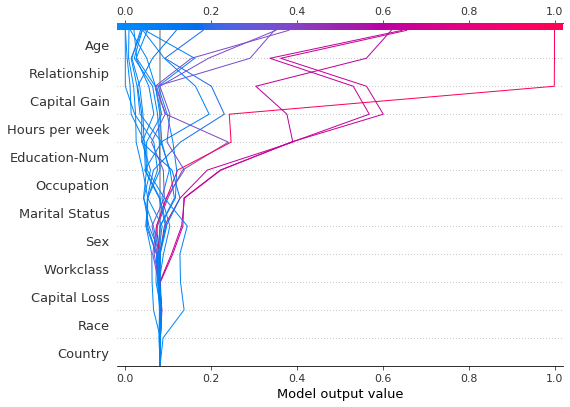

In [4]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

Observations can be highlighted using a dotted line style. Here, we highlight a misclassified observation.

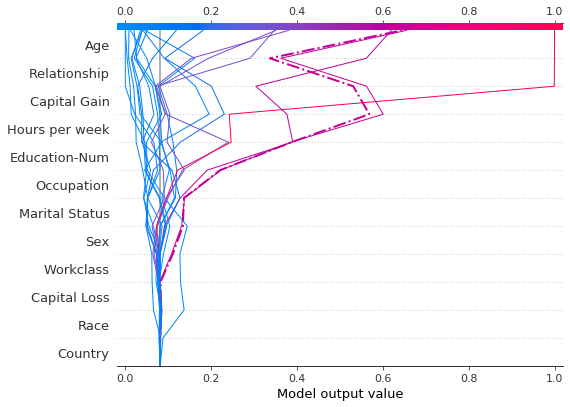

In [5]:
# Our naive cutoff point is zero log odds (probability 0.5).
y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred != y_test[select]
shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified)

Let's inspect the misclassified observation by plotting it alone. When a single observation is plotted, its corresponding feature values are displayed. Notice that the shape of the line has changed. Why? The feature order has changed on the y-axis based on the feature importance for this lone observation. The section "Preserving order and scale between plots" shows how to use the same feature order for multiple plots.

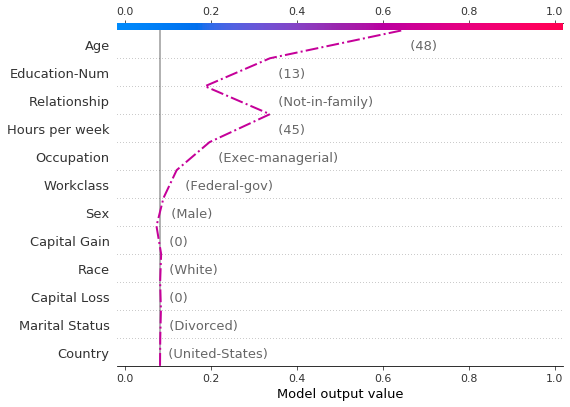

In [6]:
shap.decision_plot(expected_value, shap_values[misclassified], features_display[misclassified],
                   link='logit', highlight=0)

A force plot for the misclassified observation is shown below. In this case, the decision plot and the force plot are both effective at showing how the model arrived at its decision.

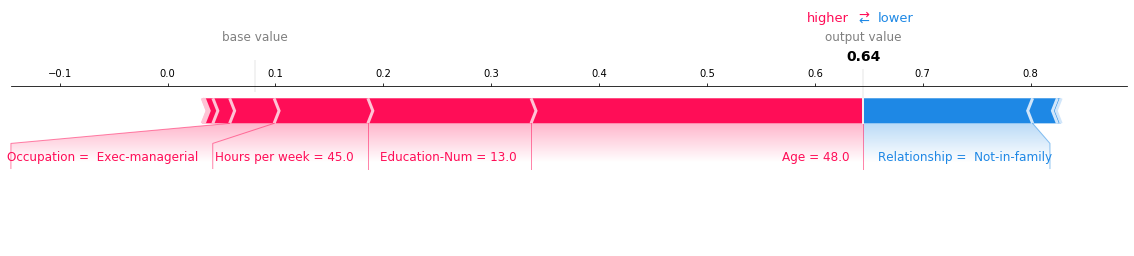

In [7]:
shap.force_plot(expected_value, shap_values[misclassified], features_display[misclassified], 
                link='logit', matplotlib=True)

# When is a decision plot helpful?
There are several use cases for a decision plot. We present several cases here.
1. Show a large number of feature effects clearly.
2. Visualize multioutput predictions.
3. Display the cumulative effect of interactions.
4. Explore feature effects for a range of feature values.
5. Identify outliers.
6. Identify typical prediction paths.
7. Compare and contrast predictions for several models.

## Show a large number of feature effects clearly
Like a force plot, a decision plot shows the important features involved in a model's output. However, a decision plot can be more helpful than a force plot when there are a large number of significant features involved. To demonstrate, we use a model trained on the [UCI Communities and Crime](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized) data set. The model uses 101 features. The two plots below describe the same prediction. The force plot's horizontal format prevents it from showing all of the significant features clearly. In contrast, the decision plot's vertical format can display the effects of any number of features.

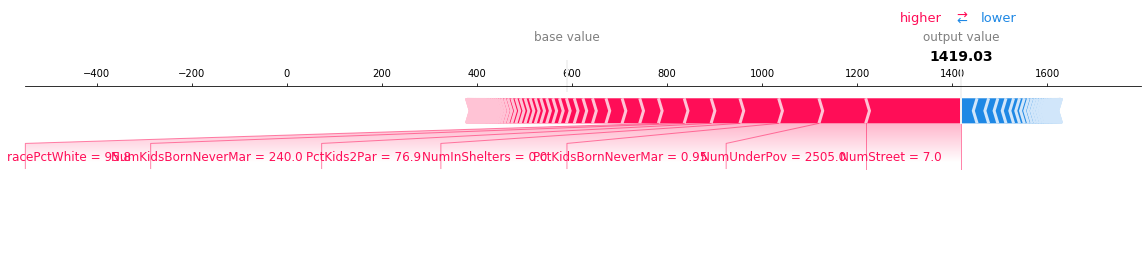

In [8]:
# Load the prediction from disk to keep the example short.
with open('./data/crime.pickle', 'rb') as fl:
    a, b, c = pickle.load(fl)
shap.force_plot(a, b, c, matplotlib=True)

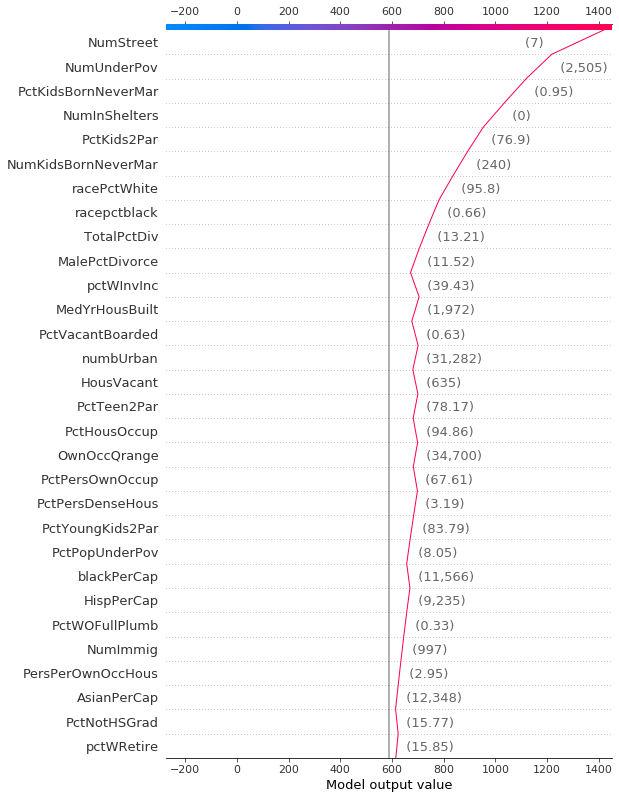

In [9]:
shap.decision_plot(a, b, c, feature_display_range=slice(None, -31, -1))

## Visualize multioutput predictions
Decision plots can show how multioutput models arrive at predictions. In this example, we use SHAP values from a Catboost model trained on the [UCI Heart Disease](https://archive.ics.uci.edu/ml/datasets/heart+Disease) data set. There are five classes that indicate the extent of the disease: Class 1 indicates no disease; Class 5 indicates advanced disease.

To keep the example short, the SHAP values are loaded from disk. The variable `heart_base_values` is a list of the SHAP expected values for each class. Likewise, the variable `heart_shap_values` is a list of SHAP matrices; one matrix per class. This is the multioutput format returned by `shap.TreeExplainer`.

In [10]:
# Load all from disk to keep the example short.
with open('./data/heart.pickle', 'rb') as fl:
    heart_feature_names, heart_base_values, heart_shap_values, heart_predictions = pickle.load(fl)
class_count = len(heart_base_values)

Create a function that generates labels for the plot legend. *Tip: Include the predicted values in the legend labels to help distinguish the classes.*

In [11]:
def class_labels(row_index):
    return [f'Class {i + 1} ({heart_predictions[row_index, i].round(2):.2f})' for i in range(class_count)]

Plot SHAP values for observation \#2 using `shap.multioutput_decision_plot`. The plot's default base value is the average of the multioutput base values. The SHAP values are adjusted accordingly to produce accurate predictions. The dashed (highlighted) line indicates the model's predicted class. For this observation, the model is confident that disease is present, but it cannot easily distinguish between classes 3, 4, and 5.

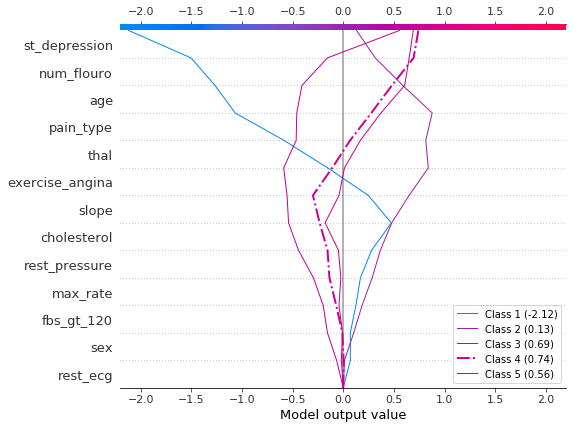

In [12]:
row_index = 2
shap.multioutput_decision_plot(heart_base_values, heart_shap_values,
                               row_index=row_index, 
                               feature_names=heart_feature_names, 
                               highlight=[np.argmax(heart_predictions[row_index])],
                               legend_labels=class_labels(row_index),
                               legend_location='lower right')    

For observation \#3, the model confidently predicts that disease is not present.

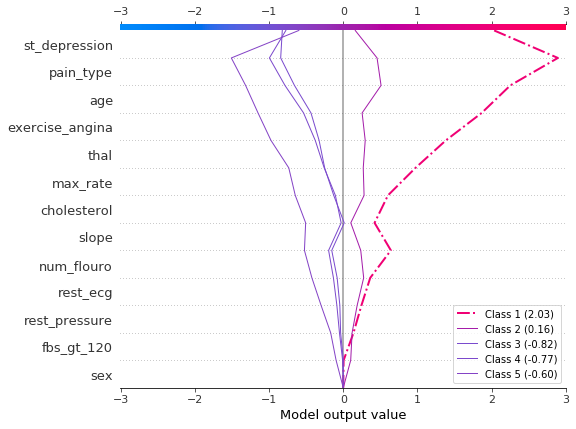

In [13]:
row_index = 3
shap.multioutput_decision_plot(heart_base_values, heart_shap_values,
                               row_index=row_index, 
                               feature_names=heart_feature_names, 
                               highlight=[np.argmax(heart_predictions[row_index])],
                               legend_labels=class_labels(row_index),
                               legend_location='lower right')    

## Display the cumulative effect of interactions
Decision plots support SHAP interaction values: the first-order interactions estimated from tree-based models. While SHAP dependence plots are the best way to visualize individual interactions, a decision plot can display the cumulative effect of main effects and interactions for one or more observations.

The decision plot here explains a single prediction from the [UCI Adult Income](https://archive.ics.uci.edu/ml/datasets/Adult) data set using both main effects and interactions. The 20 most important features are displayed. For more details relating to support for interactions, see the section "SHAP interaction values."

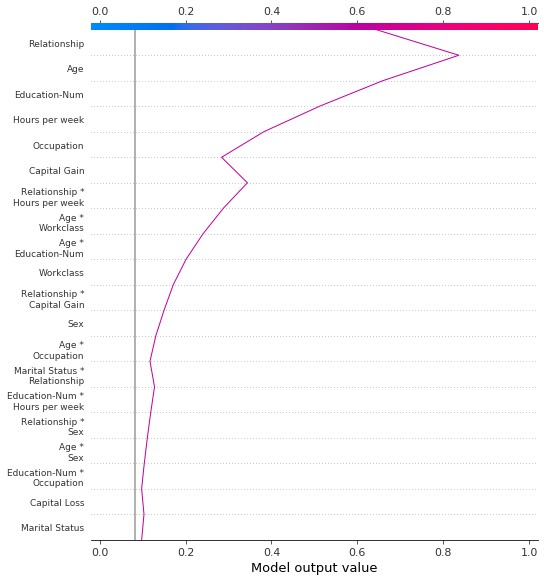

In [14]:
shap.decision_plot(expected_value, shap_interaction_values[misclassified], features_display[misclassified],
                   link='logit')

## Explore feature effects for a range of feature values
A decision plot can reveal how predictions change across a set of feature values. This method is useful for presenting hypothetical scenarios and exposing model behaviors. In this example, we create hypothetical observations that differ only by capital gain.

Start with the following reference observation from the [UCI Adult Income](https://archive.ics.uci.edu/ml/datasets/adult) data set.

In [15]:
idx = 25
X_display.loc[idx]

Age                                56
Workclass                   Local-gov
Education-Num                      13
Marital Status     Married-civ-spouse
Occupation               Tech-support
Relationship                  Husband
Race                            White
Sex                              Male
Capital Gain                        0
Capital Loss                        0
Hours per week                     40
Country                 United-States
Name: 25, dtype: object

Create a synthetic data set using several copies of the reference observation. Vary the value of 'Capital Gain' from \\$0-\\$10,000 by \\$100. Retrieve the corresponding SHAP values. This approach allows us to evaluate and debug the model. Analysts may also find this method useful for presenting hypothetical scenarios. Keep in mind that the effects for capital gains shown in this example are specific to the reference record, and therefore cannot be generalized.

In [16]:
rg = range(0, 10100, 100)
R = X.iloc[np.repeat(idx, len(rg))].reset_index(drop=True)
R['Capital Gain'] = rg

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hypothetical_shap_values = explainer.shap_values(R)[1]
    
hypothetical_predictions = expected_value + hypothetical_shap_values.sum(axis=1)
hypothetical_predictions = 1 / (1 + np.exp(-hypothetical_predictions))

This dependence plot shows the change in SHAP values across a feature's value range. The SHAP values for this model represent a change in log odds. This plot shows that there is a significant change in SHAP values around \\$5,000. It also shows some significant outliers at \\$0 and approximately \\$3,000.

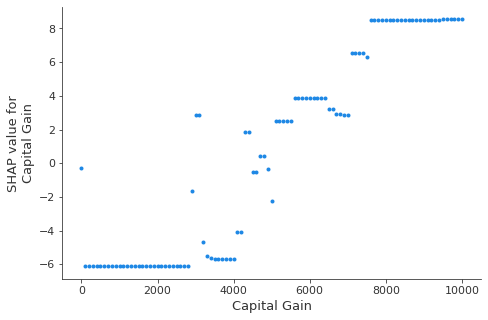

In [17]:
shap.dependence_plot('Capital Gain', hypothetical_shap_values, R, interaction_index=None)

Though the dependence plot is helpful, it is difficult to discern the practical effects of the SHAP values in context. For that purpose, we can plot the synthetic data set with a decision plot on the probability scale. First, we plot the reference observation to establish context. The prediction is probability 0.76. Capital gain is zero, for which the model assigns a small negative effect. The features have been ordered manually to match the next two plots.

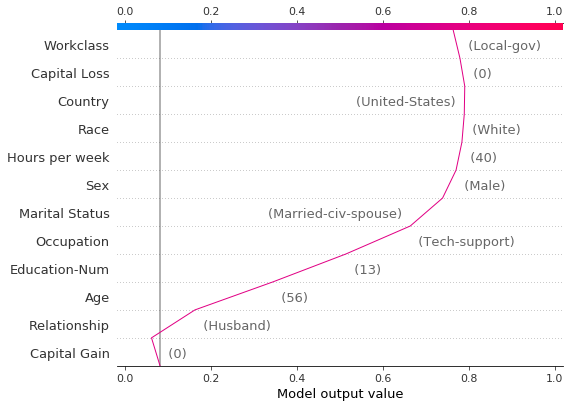

In [18]:
# The feature ordering was determined via 'hclust' on the synthetic data set. We specify the order here manually so 
# the following two plots match up.
feature_idx = [8, 5, 0, 2, 4, 3, 7, 10, 6, 11, 9, 1]
shap.decision_plot(expected_value, hypothetical_shap_values[0], X_display.iloc[idx], feature_order=feature_idx, 
                   link='logit')

Now, we plot the synthetic data. The reference record is marked with a dashed line. The features are ordered via hierarchical clustering to group similar prediction paths. We see that, in practical terms, the effect of capital gain is largely polarized; only a handful of predictions lie between 0.2 and 0.8.

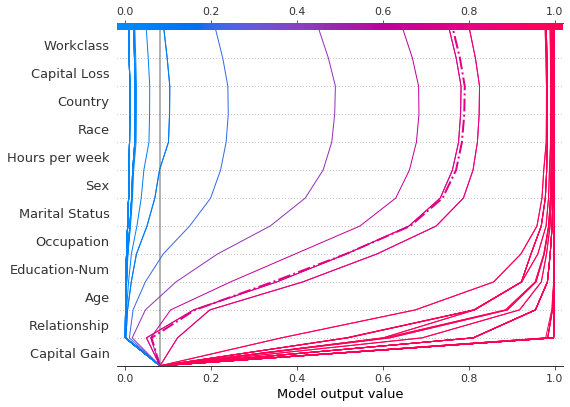

In [19]:
shap.decision_plot(expected_value, hypothetical_shap_values, R, link='logit', feature_order='hclust', highlight=0)

Upon further inspection of the predictions, we found a threshold around \\$4,300, but there are anomalies. Capital gains of \\$0, \\$3,000, and \\$3,100 contribute to unexpectedly high predictions; capital gains of \\$5,000 contributes to unexpectedly low predictions. These anomalies are plotted here with a legend to help identify each prediction. The predictions paths for \\$3,000 and \\$3,100 are identical.

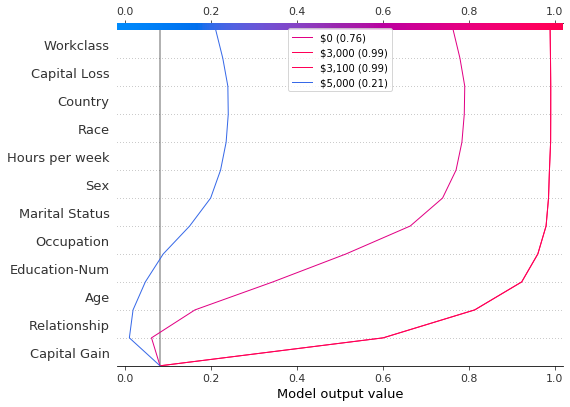

In [20]:
def legend_labels(idx):
    return [f'\${i * 100:,} ({hypothetical_predictions[i]:.2f})' for i in idx]

show_idx = [0, 30, 31, 50]
shap.decision_plot(expected_value, hypothetical_shap_values[show_idx], X, feature_order=feature_idx,
                   link='logit', legend_labels=legend_labels(show_idx), legend_location='upper center')

## Identify outliers
Decision plots can help identify outliers. Specify `feature_order='hclust'` to groups observations with similar prediction paths. This often makes outliers easier to spot. Avoid using `link='logit'` when plotting outliers because predictions of amplitude are distorted by the sigmoid function.

The plot below shows all predictions in the probability range [0.03, 0.1]. (Predictions less than 0.03 are excluded in this example because they represent a large number of observations.) Two predictions immediately stand out. The effects of 'Age', 'Capital Loss', and 'Capital Gain' are most prominent.

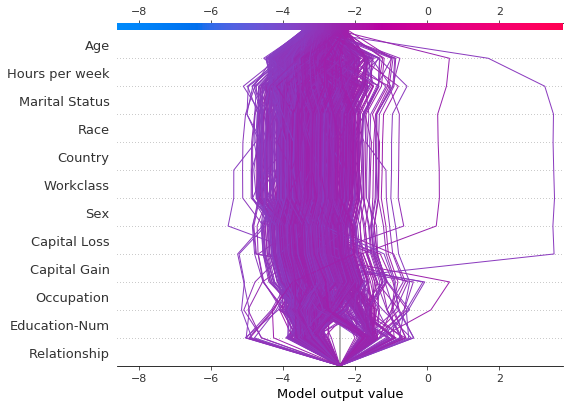

In [21]:
y_pred = model.predict(X_test)  # Get predictions on the probability scale.
T = X_test[(y_pred >= 0.03) & (y_pred <= 0.1)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[1]
r = shap.decision_plot(expected_value, sh, T, feature_order='hclust', return_objects=True)

Locate the outliers based on their SHAP values and plot them with their feature values. The outliers are plotted using the same feature order and scale as the original plot. See "Preserving order and scale between plots" for more details.

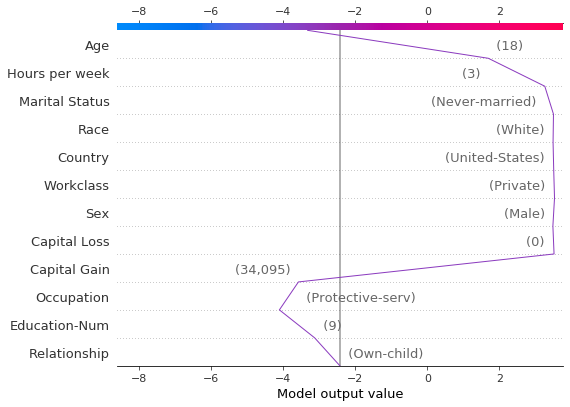

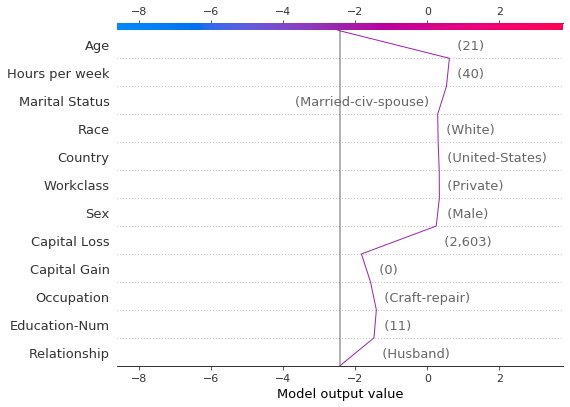

In [22]:
# Find the two observations with the most negative 'Age' SHAP values.
idx = np.argpartition(sh[:, T.columns.get_loc('Age')], 2)[0:2]

# Plot the observations individually with their corresponding feature values. The plots use the same feature order 
# as the original plot.
for i in idx:
    shap.decision_plot(expected_value, sh[i], X_display.loc[T.index[i]], feature_order=r.feature_idx, xlim=r.xlim)

## Identify typical prediction paths
A decision plot can expose a model's typical prediction paths. Here, we plot all of the predictions in the probability interval [0.98, 1.0] to see what high-scoring predictions have in common. We use `'hclust'` feature ordering to group similar prediction paths. The plot shows two distinct paths: one is dominated by 'Capital Gain' while the other is dominated by 'Capital Loss'. The effects of 'Relationship', 'Age', and 'Education-Num' are also notable.

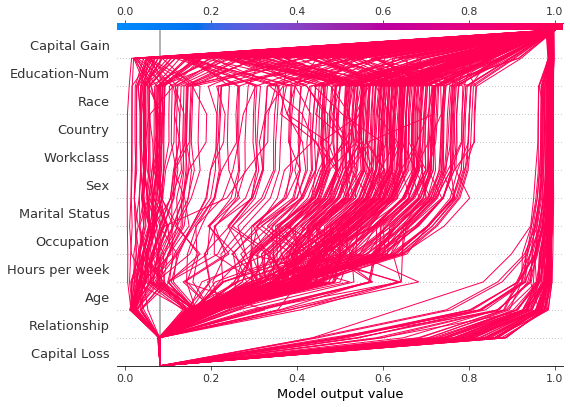

In [23]:
y_pred = model.predict(X_test)  # Get predictions on the probability scale.
T = X_test[y_pred >= 0.98]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[1]
shap.decision_plot(expected_value, sh, T, feature_order='hclust', link='logit')

## Compare and contrast predictions for several models
Decision plots are useful for comparing predictions from different models, or for interpreting the predictions of an ensemble of models. In this example, we plot the predictions from an ensemble of five LightGBM models trained on the [UCI Adult Income](https://archive.ics.uci.edu/ml/datasets/adult) data set. In this example, we create an ensemble of five models and plot the models' predictions using `shap.multioutput_decision_plot`.

Train an ensemble of five LightGBM models using 5-fold CV.

In [26]:
model_count = 5
skf = StratifiedKFold(model_count, True, random_state=random_state)
models = []
for t, v in skf.split(X, y):
    m = lgb.LGBMClassifier(**params, n_estimators=1000)
    m.fit(X.iloc[t], y[t], eval_set=(X.iloc[v], y[v]), early_stopping_rounds=50, verbose=False)
    score = m.best_score_['valid_0']['binary_logloss']
    print(f'Best score: {score}')
    models.append(m)

Best score: 0.28279460948508833
Best score: 0.2743920496745268
Best score: 0.2706647518976772
Best score: 0.2809048231217079
Best score: 0.2785044277595166


Assemble the models' base values and SHAP values into lists. This mimics the `shap` package's output for multioutput models.

In [27]:
def get_ensemble_shap_values(models, X):
    base_values = [None] * model_count
    shap_values = [None] * model_count
    predictions = [None] * model_count
    for i, m in enumerate(models):
        a = m.predict(X, pred_contrib=True)  # `pred_contrib=True` returns SHAP values for LightGBM
        base_values[i] = a[0, -1]  # The last column in the matrix is the base value.
        shap_values[i] = a[:, 0:-1]
        predictions[i] = 1 / (1 + np.exp(-a.sum(axis=1)[0]))  # Predictions as probabilities
    return base_values, shap_values, predictions

Retrieve the SHAP values from the ensemble for a single observation.

In [28]:
ensemble_base_values, ensemble_shap_values, ensemble_predictions = get_ensemble_shap_values(models, X.iloc[[27]])

Plot the SHAP values. A legend identifies each model's prediction. *Tip: Include the predicted values in the legend labels to help distinguish the models.*

If probability 0.5 is our cutoff value for this binary classification task, we see that this observation is difficult to classify. However, Model 2 is confident that the individual makes less than \\$50K per year. If this is an exemplar observation, it might be worth examining why this model's prediction is different.

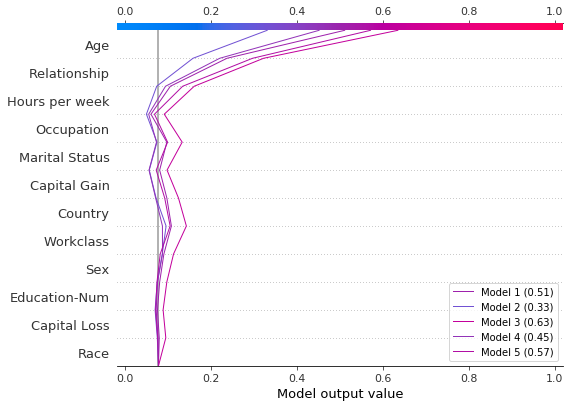

In [29]:
# Create labels for legend
labels = [f'Model {i + 1} ({ensemble_predictions[i].round(2):.2f})' for i in range(model_count)]

# Plot
shap.multioutput_decision_plot(ensemble_base_values, ensemble_shap_values, 0, feature_names=X.columns.to_list(), 
                               link='logit', legend_labels=labels, legend_location='lower right')

# SHAP interaction values
The decision plot supports SHAP interaction values as shown here. Notice that the lines do not completely converge to `explainer.expected_value` at the bottom of the plot. This is because there are N(N + 1)/2 = 12(13)/2 = 78 features including interaction and main effects, but the decision plot shows only the 20 most important features by default. See the section "Selecting features to display" to learn how to show more features.

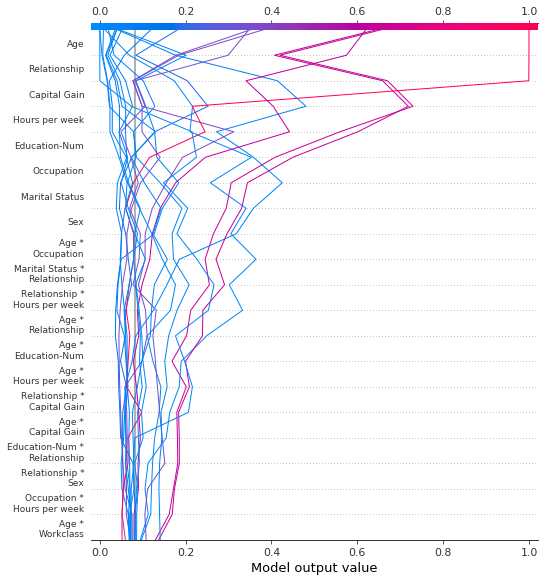

In [30]:
shap.decision_plot(expected_value, shap_interaction_values, features, link='logit')

The decision plot transforms the three-dimensional SHAP interaction structure to a standard two-dimensional SHAP matrix. It also generates corresponding feature labels. These structures can be retrieved from a decision plot by setting `return_objects=True`. In this example, we omit the plot by setting `show=False`.

In [31]:
r = shap.decision_plot(expected_value, shap_interaction_values, features, link='logit',
                       show=False, return_objects=True)
plt.close()
print("SHAP dimensions: {}".format(r.shap_values.shape), "\n")
pprint(r.feature_names[:-11:-1])

SHAP dimensions: (20, 78) 

['Age',
 'Relationship',
 'Capital Gain',
 'Hours per week',
 'Education-Num',
 'Occupation',
 'Marital Status',
 'Sex',
 'Age *\nOccupation',
 'Marital Status *\nRelationship']


# Preserving order and scale between plots

It is often helpful to create several decision plots using the same feature order and x-axis scale to facilitate direct comparisons. When `return_objects=True`, the decision plot returns plotting structures that can be used in subsequent plots.

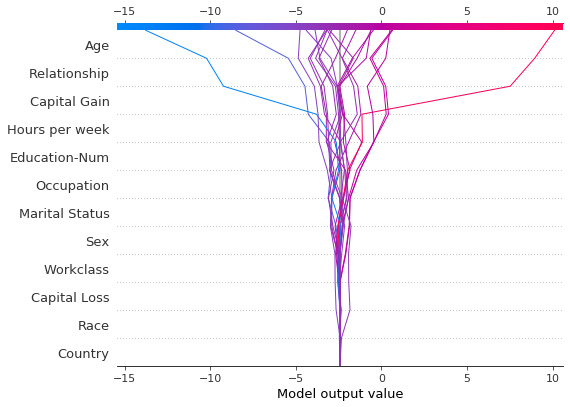

In [32]:
# Create the first plot, returning the plot structures.
r = shap.decision_plot(expected_value, shap_values, features_display, return_objects=True)

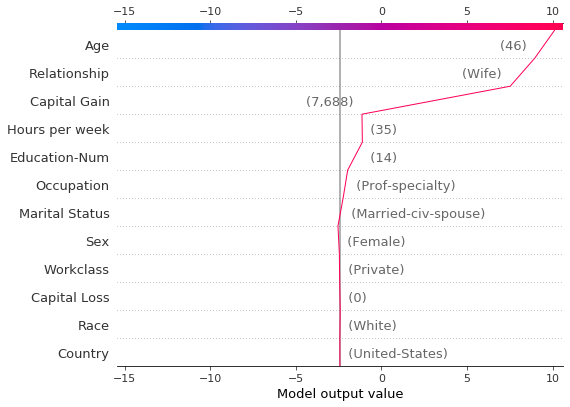

In [33]:
# Create another plot using the same feature order and x-axis extents.
idx = 9
shap.decision_plot(expected_value, shap_values[idx], features_display.iloc[idx],
                   feature_order=r.feature_idx, xlim=r.xlim)

# Selecting features for display
The features displayed in a decision plot are controlled by two parameters: `feature_order` and `feature_display_range`. The `feature_order` parameter determines how the features are ordered before display. The `feature_display_range` parameter determines which of the ordered features are displayed. It takes either a `slice` or a `range` object as an argument. The `feature_display_range` parameter also controls whether the features are plotted in ascending or descending order.

For example, if `feature_order='importance'` (the default), the decision plot arranges the features in *ascending* order by importance before display. If `feature_display_range=slice(-1, -21, -1)` (the default), the plot shows the last (i.e., the most important) 20 features in descending order. The object `slice(-1, -21, -1)` is interpreted as "start at the last feature and iterate to the 21st feature from the end by a step of -1." The end point, -21, is not included.

The `feature_display_range` parameter is particularly important when `'hclust'` ordering is applied. In this case, many of the significant features are positioned at the beginning of the feature range. However, the decision plot shows the end of the feature range by default.

The following plot shows the first 10 out of 78 SHAP interaction features using `'hclust'` ordering. *Note: Because we show only the first 10 features, the observations do not strike the x-axis at their final predicted values.* The snippet `feature_display_range=range(10, -1, -1)` indicates that we start at feature 10 and count to feature -1 by -1. The end point is not included in the range. Hence, we see the features 10 to 0.

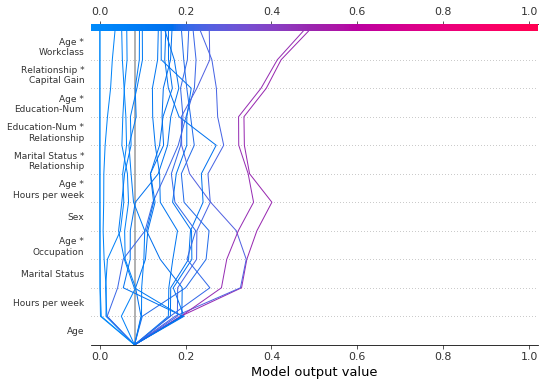

In [34]:
shap.decision_plot(expected_value, shap_interaction_values, features, link='logit', 
                   feature_order='hclust', feature_display_range=range(10, -1, -1))

We can produce the same plot in ascending order by specifying an ascending range: `range(0, 11, 1)`.

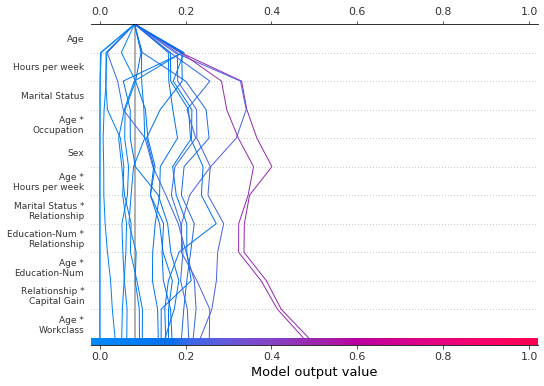

In [35]:
shap.decision_plot(expected_value, shap_interaction_values, features, link='logit', 
                   feature_order='hclust', feature_display_range=range(0, 11, 1))

When selecting the last features in a range, it is more convenient to use a slice because slices support negative indices. For example, the index -20 indicates the 20th item from the end. The following plot shows the last 10 features in descending `'hclust'` order.

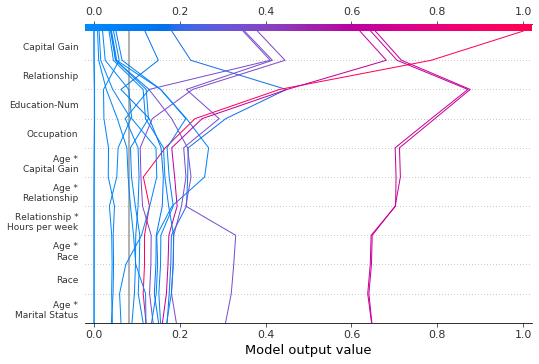

In [36]:
shap.decision_plot(expected_value, shap_interaction_values, features, link='logit', 
                   feature_order='hclust', feature_display_range=slice(None, -11, -1))

We can display all available features in a number of ways. The simplest is `feature_display_range=slice(None, None, -1)`. *Note: If your dataset contains many features, this will produce a very large plot.*

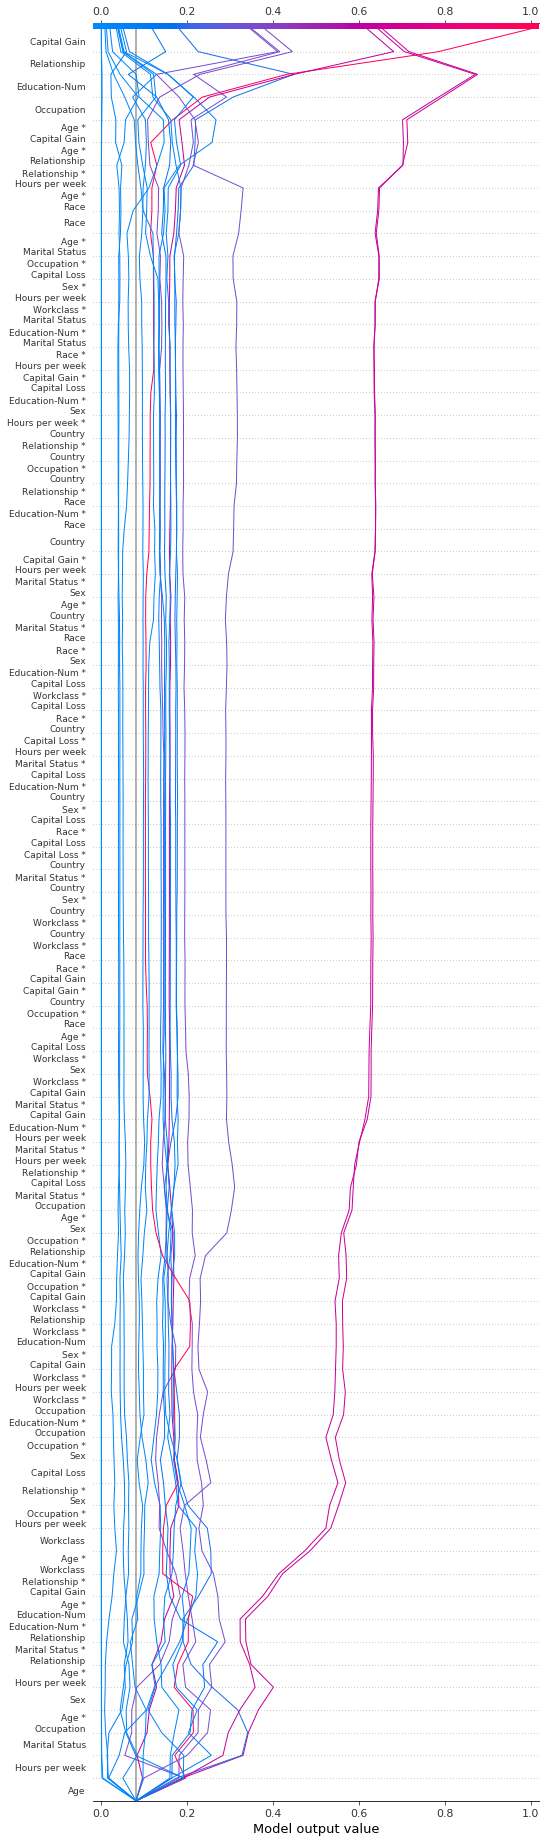

In [37]:
shap.decision_plot(expected_value, shap_interaction_values, features, link='logit', 
                   feature_order='hclust', feature_display_range=slice(None, None, -1))

# Changing the SHAP base value
SHAP values are all relative to some base value. By default, the base value is `explainer.expected_value`: the mean of the raw model predictions for the training data.

In [38]:
# The model's training mean
print(model.predict(X_train, raw_score=True).mean().round(4))

# The explainer expected value
print(expected_value.round(4))

-2.4297
-2.4297


To obtain raw prediction values, `explainer.expected_value` is added to the sum of SHAP values for each observation.

In [39]:
# The model's raw prediction for the first observation.
print(model.predict(features.iloc[[0]].values, raw_score=True)[0].round(4))

# The corresponding sum of the mean + shap values
print((expected_value + shap_values[0].sum()).round(4))

-3.1866
-3.1866


Hence, `explainer.expected_value` must be provided to the decision plot to produce correct predictions.

In the decision plot, the base value is the starting value for each prediction at the bottom of the plot. Using `explainer.expected_value` as the base value is not always visually intuitive. Consider a logistic classification problem. If we choose probability 0.4 as our cutoff value, it might make more sense if the predictions converge at the cutoff point instead of `explainer.expected_value`. To this end, the decision plot provides the `new_base_value` argument. It shifts the SHAP base value to an arbitrary point without altering the predicted values.

In this example, we specify probability 0.4 as the new base value. Because our model's SHAP values are in log odds, we convert the probability to log odds before passing it to the decision plot. The `link='logit'` argument converts the base values and SHAP values to probabilities.

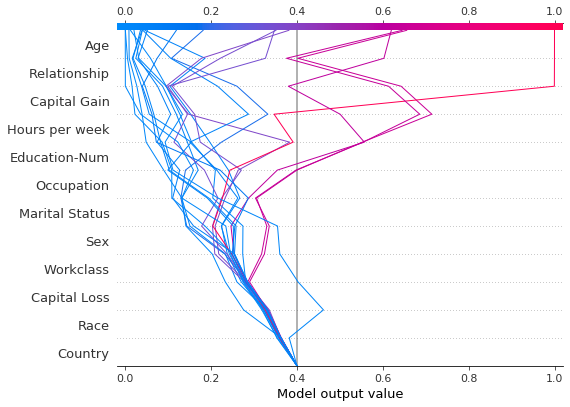

In [40]:
p = 0.4  # Probability 0.4
new_base_value = np.log(p / (1 - p))  # the logit function
shap.decision_plot(expected_value, shap_values, features_display, link='logit', new_base_value=new_base_value)

For comparision, here is the decision plot with the original base value.

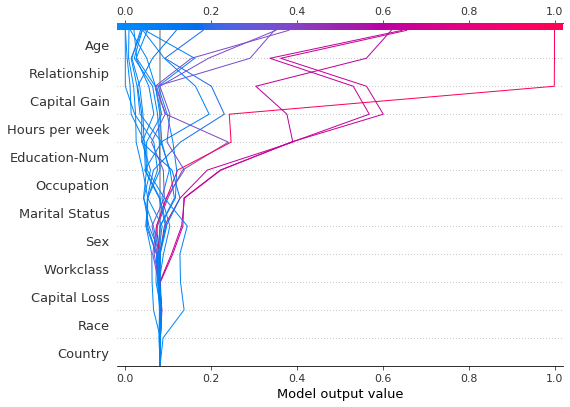

In [41]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')